In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%matplotlib widget

In [3]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

### Reference: Influence of hole shape on sound absorption of underwater anechoic layers
#### https://www.sciencedirect.com/science/article/abs/pii/S0022460X1830227X

### Import pre-defined class and function

In [4]:
%run -i hole_shape_sound_absorption.py

### Define the determinant of the coefficient matrix of eq(14) in the paper

In [5]:
determinant, mat = determinant_from_matrix()
mat

Matrix([
[                                                                                                              -sqrt(-kz**2 + omega**2/cl**2)*besselj(1, b*sqrt(-kz**2 + omega**2/cl**2)),                                                                                                               -sqrt(-kz**2 + omega**2/cl**2)*bessely(1, b*sqrt(-kz**2 + omega**2/cl**2)),                                                                                      -I*kz*sqrt(-kz**2 + omega**2/ct**2)*besselj(1, b*sqrt(-kz**2 + omega**2/ct**2)),                                                                                      -I*kz*sqrt(-kz**2 + omega**2/ct**2)*bessely(1, b*sqrt(-kz**2 + omega**2/ct**2))],
[(-2*mu*(-kz**2 + omega**2/cl**2) - lambda*omega**2/cl**2)*besselj(0, a*sqrt(-kz**2 + omega**2/cl**2)) + 2*mu*sqrt(-kz**2 + omega**2/cl**2)*besselj(1, a*sqrt(-kz**2 + omega**2/cl**2))/a, (-2*mu*(-kz**2 + omega**2/cl**2) - lambda*omega**2/cl**2)*bessely(0, a*sqrt(-kz**2 + omega**2/cl**

### Define the frequency array by np.arange

In [6]:
# np.arange?

In [7]:
# frequency_array = np.arange(20, 10021, 100)
# frequency_array

## Define an object of sound_performance for calculating sound absorption
### The default values are listed as below (all in SI units)

Material of anechoic layer: rubber

Young's modulus of rubber (GPa): 0.14

Loss factor of rubber 0.23

Poisson ratio of rubber 0.49

Density of rubber (kg/m3): 1100

Density of air (kg/m3): 1.21

Shape: cone

p = 4 mm

q = 8 mm

lh = 40 mm

cell_radius = 15 mm

num_segments = 100

Density of water (kg/m3): 998

Sound speed of water (m/s): 1483

#### https://en.wikipedia.org/wiki/Lam%C3%A9_parameters

In [8]:
frequency_array = np.arange(2, 10052, 40)
# frequency_array2 = np.arange(2, 10022, 20)
frequency_array.shape

(252,)

### Example 01: define all parameters by nechoic_sound_absorption()

In [9]:
cone_6_3 = anechoic_sound_absorption(determinant, frequency_array,
                              fp = '/Users/chenghunglin/Documents/', 
                              fn = 'cone_6_3_fr50.xlsx', 
                              material='rubber', shape='cone', 
                              p=6e-3, q=3e-3, lh=40e-3, cell_radius=15e-3, 
                              num_segments=100, layer_density=1100, air_density=1.21, 
                              Young_modulus=0.14e9, Poisson_ratio=0.49, loss_factor=0.23, 
                              medium_density=998, sound_speed_medium=1483)

Solving wavenumber in determinant for shape = cone, p = 0.006, q = 0.003, Young's = 140000000.0


Solving for all frequencies:   0%|          | 0/252 [00:00<?, ?it/s]

  ... working at frequency = 2.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 42.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 82.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 122.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 162.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 242.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 282.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 322.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 362.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 442.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 482.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 522.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 562.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 642.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 682.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 722.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 762.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 842.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 882.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 922.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 962.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1042.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1082.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1122.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1162.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1242.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1282.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1322.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1362.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1442.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1482.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1522.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1562.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1642.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1682.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1722.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1762.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1842.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1882.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1922.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1962.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2042.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2082.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2122.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2162.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2242.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2282.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2322.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2362.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2442.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2482.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2522.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2562.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2642.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2682.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2722.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2762.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2842.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2882.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2922.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2962.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3042.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3082.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3122.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3162.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3242.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3282.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3322.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3362.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3442.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3482.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3522.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3562.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3642.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3682.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3722.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3762.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3842.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3882.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3922.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3962.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4042.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4082.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4122.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4162.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4242.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4282.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4322.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4362.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4442.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4482.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4522.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4562.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4642.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4682.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4722.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4762.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4842.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4882.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4922.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4962.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5042.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5082.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5122.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5162.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5242.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5282.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5322.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5362.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5442.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5482.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5522.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5562.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5642.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5682.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5722.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5762.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5842.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5882.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5922.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5962.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6042.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6082.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6122.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6162.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6242.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6282.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6322.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6362.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6442.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6482.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6522.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6562.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6642.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6682.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6722.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6762.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6842.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6882.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6922.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6962.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7042.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7082.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7122.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7162.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7242.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7282.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7322.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7362.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7442.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7482.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7522.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7562.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7642.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7682.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7722.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7762.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7842.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7882.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7922.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7962.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8042.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8082.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8122.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8162.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8242.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8282.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8322.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8362.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8442.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8482.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8522.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8562.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8642.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8682.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8722.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8762.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8842.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8882.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8922.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8962.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9042.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9082.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9122.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9162.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9242.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9282.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9322.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9362.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9442.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9482.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9522.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9562.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9642.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9682.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9722.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9762.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9842.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9882.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9922.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9962.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 10002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 10042.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]



self.frequency_array.shape[0] = 252 is same as self.wavenumer_array.shape[0] = 252
Save file to /Users/chenghunglin/Documents/cone_6_3_fr50.xlsx


self.frequency_array.shape[0] = 252 is same as self.wavenumer_array.shape[0] = 252


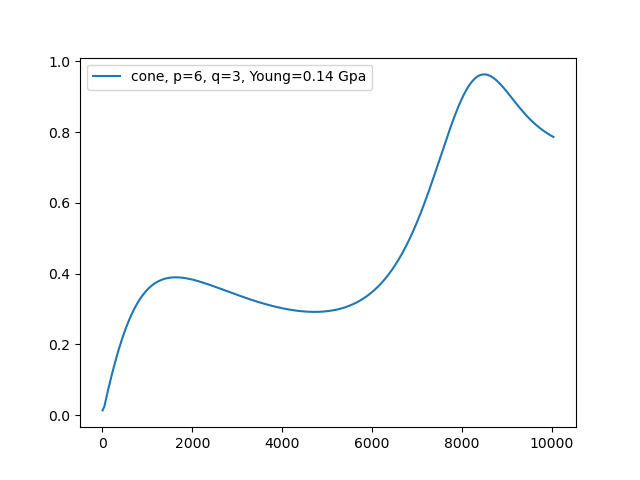

In [10]:
plt.figure()
plt.plot(cone_6_3.frequency_array, cone_6_3.absorption_frequency(), label='cone, p=6, q=3, Young=0.14 Gpa')
# plt.plot(cone_4_8.frequency_array, cone_4_8.absorption_frequency(), label='cone, p=4, q=8, Young=0.14 Gpa')
# plt.plot(cone_4_8_3.frequency_array, cone_4_8_3.absorption_frequency(), '--', color='orange', label='cone, p=4, q=8, Young=0.014 Gpa')
# plt.plot(horn_1_11.frequency_array, horn_1_11.absorption_frequency(), label='horn, p=1, q=11, seg=50, fr=50')
# plt.plot(horn_1_11_seg100.frequency_array, horn_1_11_seg100.absorption_frequency(), label='horn, p=1, q=11, seg=100, fr=50')
# plt.plot(horn_1_11_fr20.frequency_array, horn_1_11_fr20.absorption_frequency(), label='horn, p=1, q=11, seg=100, fr=20')
plt.legend()

### Example 02: change parameters through sound_performance() objects

In [11]:
horn_1_11 = sound_performance(determinant, frequency_array)

In [12]:
horn_1_11.shape = 'horn'
horn_1_11.p_hole = 1e-3
horn_1_11.q_hole = 11e-3

In [13]:
## Find roots of wavenumber in the equation of determinant
horn_1_11.wavenumer_array, horn_1_11.failed_root = horn_1_11.axial_wavenumber_array()

Solving wavenumber in determinant for shape = horn, p = 0.001, q = 0.011, Young's = 140000000.0


Solving for all frequencies:   0%|          | 0/252 [00:00<?, ?it/s]

  ... working at frequency = 2.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 42.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 82.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 122.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 162.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 242.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 282.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 322.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 362.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 442.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 482.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 522.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 562.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 642.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 682.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 722.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 762.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 842.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 882.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 922.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 962.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1042.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1082.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1122.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1162.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1242.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1282.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1322.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1362.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1442.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1482.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1522.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1562.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1642.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1682.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1722.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1762.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1842.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1882.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1922.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 1962.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2042.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2082.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2122.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2162.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2242.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2282.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2322.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2362.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2442.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2482.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2522.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2562.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2642.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2682.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2722.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2762.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2842.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2882.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2922.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 2962.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3042.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3082.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3122.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3162.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3242.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3282.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3322.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3362.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3442.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3482.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3522.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3562.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3642.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3682.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3722.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3762.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3842.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3882.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3922.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 3962.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4042.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4082.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4122.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4162.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4242.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4282.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4322.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4362.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4442.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4482.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4522.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4562.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4642.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4682.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4722.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4762.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4842.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4882.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4922.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 4962.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5042.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5082.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5122.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5162.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5242.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5282.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5322.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5362.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5442.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5482.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5522.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5562.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5642.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5682.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5722.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5762.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5842.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5882.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5922.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 5962.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6042.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6082.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6122.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6162.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6242.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6282.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6322.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6362.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6442.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6482.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6522.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6562.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6642.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6682.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6722.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6762.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6842.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6882.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6922.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 6962.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7042.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7082.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7122.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7162.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7242.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7282.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7322.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7362.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7442.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7482.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7522.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7562.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7642.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7682.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7722.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7762.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7842.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7882.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7922.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 7962.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8042.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8082.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8122.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8162.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8242.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8282.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8322.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8362.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8442.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8482.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8522.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8562.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8642.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8682.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8722.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8762.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8842.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8882.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8922.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 8962.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9042.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9082.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9122.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9162.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9202.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9242.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9282.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9322.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9362.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9402.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9442.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9482.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9522.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9562.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9602.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9642.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9682.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9722.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9762.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9802.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9842.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9882.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9922.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 9962.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 10002.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

  ... working at frequency = 10042.0 Hz:   0%|          | 0/100 [00:00<?, ?it/s]

In [14]:
## Save the data
fp = '/Users/chenghunglin/Documents/'
fn = 'horn_1_11.xlsx'
horn_1_11.save_data(fp, fn)

self.frequency_array.shape[0] = 252 is same as self.wavenumer_array.shape[0] = 252
Save file to /Users/chenghunglin/Documents/horn_1_11.xlsx


## Plot data to compare with the paper

self.frequency_array.shape[0] = 252 is same as self.wavenumer_array.shape[0] = 252


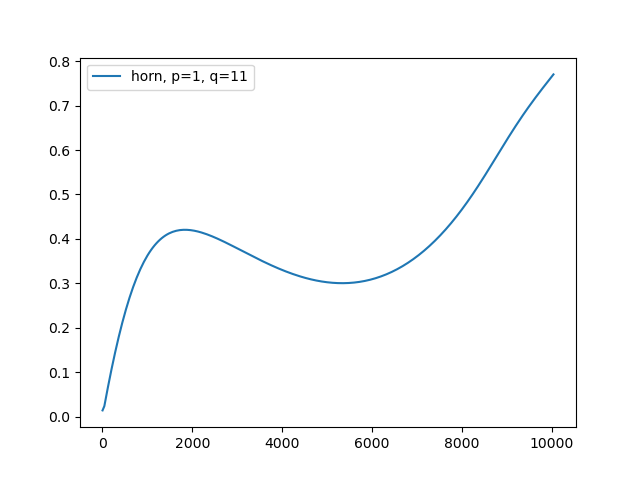

In [15]:
plt.figure()
# plt.plot(cone_4_8.frequency_array, cone_4_8.absorption_frequency(), label='cone, p=4, q=8, Young=0.14 Gpa')
# plt.plot(cone_4_8_1.frequency_array, cone_4_8_1.absorption_frequency(), label='cone, p=4, q=8, Young=0.014 Gpa')
# plt.plot(cone_4_8_3.frequency_array, cone_4_8_3.absorption_frequency(), '--', color='orange', label='cone, p=4, q=8, Young=0.014 Gpa')
plt.plot(horn_1_11.frequency_array, horn_1_11.absorption_frequency(), label='horn, p=1, q=11')
plt.legend()

In [ ]:
# plt.figure()
# plt.plot(cone_4_8.frequency_array, cone_4_8.absorption_frequency(), color='blue', label='cone, p=4, q=8, Young=0.14 Gpa, step=200Hz')
# plt.plot(cone_4_8_4.frequency_array, cone_4_8_4.absorption_frequency(), '--', color='blue',label='cone, p=4, q=8, Young=0.14 Gpa, step=25Hz')
# plt.plot(cone_4_8_1.frequency_array, cone_4_8_1.absorption_frequency(), color='orange', label='cone, p=4, q=8, Young=0.014 Gpa, step=200Hz')
# plt.plot(cone_4_8_5.frequency_array, cone_4_8_5.absorption_frequency(), '--', color='orange', label='cone, p=4, q=8, Young=0.014 Gpa, step=25Hz')
# plt.plot(horn_1_11.frequency_array, horn_1_11.absorption_frequency(), label='horn, p=1, q=11')
# legend_properties = {'weight':'regular', 'size':8}    
# plt.legend(prop=legend_properties, loc='upper left') #, bbox_to_anchor=(1, 0.5))
# plt.legend()